In [1]:
import pandas as pd

## Загружаем данные

In [2]:
data_dir = '../data/random_data'

In [3]:
tracks = pd.read_csv('{}/tracks.csv'.format(data_dir), index_col=0)
artists = pd.read_csv('{}/artists.csv'.format(data_dir), index_col=0)
albums = pd.read_csv('{}/albums.csv'.format(data_dir), index_col=0)
transactions = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
playlists = pd.read_csv('{}/playlists.csv'.format(data_dir), index_col=0)

К каждой транзакции добавляем признаки популярность(popular), артист(artistid), альбом(albumid) трека, имя плейлиста(name), num_followers плейлиста

In [4]:
def get_full_dataset(transactions, tracks, playlists):
    full_dataset = pd.merge(transactions, tracks, how='left', on='trackid')
    full_dataset = pd.merge(full_dataset, playlists, how='left', on='pid')
    return full_dataset

Рейтинг определяем единичкой

In [5]:
full_dataset = get_full_dataset(transactions, tracks, playlists)
full_dataset['rating'] = 1
full_dataset.head()

,pid,trackid,popular,artistid,albumid,name,num_followers,rating
0,822032,2283,3384,1151,1618,party time,1,1
1,822032,2288,4339,1152,1622,party time,1,1
2,822032,907,4992,500,687,party time,1,1
3,822032,2289,1822,503,690,party time,1,1
4,822032,910,2160,503,690,party time,1,1


In [6]:
full_dataset.shape

(210950, 8)

Импортируем основные модули

In [7]:
from polara.recommender.models import RecommenderModel
from polara.recommender.data import RecommenderData
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy import sparse
from polara.recommender.coldstart.data import ItemColdStartData
from polara.recommender.models import SVDModel
from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
import LocalCollectiveEmbeddings as LCE

### Описания модели

- $\textbf{R}$ - матрица playlist-track
- $\textbf{X}$ - матрица playlist-feuture
- $\textbf{A}$ - матрица близости плейлистов
- $\textbf{D}$ - диагональная матрица суммы строк $\textbf{A}$
- $\textbf{L} = D - A$ - лапласиан

$$J = \frac{1}{2}[\alpha||\textbf{R} - \textbf{UV}||_F^2 + (1 - \alpha)||\textbf{X} - \textbf{UH}||_F^2 + \beta Tr(\textbf{U}^T\textbf{LU}) + \lambda(||\textbf{U}||_F^2 + ||\textbf{V}||_F^2 + ||\textbf{H}||_F^2]$$

$$arg \min_{\textbf{U}, \textbf{V}, \textbf{H}} J$$
$$s.t. U \geq 0, V \geq 0, H \geq 0$$

Обновление $\textbf{U}, \textbf{V} , \textbf{H}$:

- $$U = U * \frac{\alpha\textbf{R}\textbf{V}^T + (1 -\alpha)\textbf{X}\textbf{H}^T + \beta\textbf{AU}}{\alpha\textbf{UV}\textbf{V}^T + (1 - \alpha)\textbf{UH}\textbf{H}^T + \beta\textbf{DU} + \lambda\textbf{U}}$$
- $$V = V * \frac{\alpha\textbf{U}^T\textbf{R}}{\alpha\textbf{U}^T\textbf{UV} + \lambda\textbf{V}}$$
- $$H = H * \frac{(1 - \alpha)\textbf{U}^T\textbf{X}}{(1 - \alpha)\textbf{U}^T\textbf{UH} + \lambda\textbf{H}}$$

$*$ - поэлементное умножение
$\frac{\dots}{\dots}$ - поэлементное деление

### Класс LocalCollectiveEmbeddings

- get_train_content - получить признаки транзакций, content_data - df с признаками
- get_content_shape - возвращает количество столбцов для каждого признака
- get_training_content_matrix - возвращает матрицу features $n \times v$ где n - кол-во плейлистов, v - количество признаков
- get_test_content_matrix - аналогично для тестовой выборки
- construct_closeness_matrix - строит матрицу близости плейлистов для по признакому описанию
- update_factors - обновляет матрицы U, V, H по правилам выше
- build - возвращает матрицу факторов плейлистов, треков, признаков
    - аргументы df с признаками, параметры модели, maxiter, verbose

In [8]:
def cross_validation_lce(data, n_splits=5, seed=1, test_size=0.05, 
                         topk=500, rank=10, maxiter=10000, epsilon=0.1, 
                         alpha=.9, lamb=0.001, beta=0.05):
    
    index_content = LCE.reindex_content_columns(data, ['artistid', 'albumid'])
    
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores_lce = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    scores_svd = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        train_albums = train.albumid.unique()
        train_artists = train.artistid.unique()
        test = test.query('albumid in @train_albums')
        test = test.query('artistid in @train_artists')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        lce = LCE.LocalCollectiveEmbeddings(data_model)
        lce.build(train[['pid', 'name', 'artistid', 'albumid']], verbose=False, rank=rank, maxiter=maxiter, 
                  alpha=alpha, epsilon=epsilon, beta=beta, lamb=lamb)
        
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        lce.topk = topk
        lce.swith_positive = 1
        
        svd.topk = topk
        svd.swith_positive = 1
        
        hits = lce.evaluate()
        relevance = lce.evaluate('relevance')
        ranking = lce.evaluate('ranking')
        
        scores_lce['precision'].append(relevance.precision)
        scores_lce['recall'].append(relevance.recall)
        scores_lce['miss_rate'].append(relevance.miss_rate)
        scores_lce['nDCG'].append(ranking.nDCG)
        
        print('lce hits', hits)
        
        hits = svd.evaluate()
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')        
        
        scores_svd['precision'].append(relevance.precision)
        scores_svd['recall'].append(relevance.recall)
        scores_svd['miss_rate'].append(relevance.miss_rate)
        scores_svd['nDCG'].append(ranking.nDCG)
        
        print ('svd hits', hits)
        
    result_lce = pd.DataFrame(scores_lce)
    result_svd = pd.DataFrame(scores_svd)
    return result_lce, result_svd

In [9]:
import tqdm

In [10]:
ranks = [3, 5, 10, 15, 25, 50, 100]
lambs = [1]
result = {'recall_lce':[],'recall_lce_std':[], 
          'recall_svd':[], 'recall_svd_std':[], 
          'nDCG_lce': [], 'nDCG_lce_std': [], 
          'nDCG_svd': [], 'nDCG_svd_std': []}
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    result_lce, result_svd = cross_validation_lce(full_dataset,n_splits=5, topk=10, test_size=0.1,
                                                  rank=rank, alpha=0.9, epsilon=1e-12, 
                                                  lamb=1., beta=0.05)
    result['recall_lce'].append(result_lce.recall.mean())
    result['recall_lce_std'].append(result_lce.recall.std())
    result['nDCG_lce'].append(result_lce.nDCG.mean())
    result['nDCG_lce_std'].append(result_lce.nDCG.std())
    result['recall_svd'].append(result_svd.recall.mean())
    result['recall_svd_std'].append(result_svd.recall.std())
    result['nDCG_svd'].append(result_svd.nDCG.mean())
    result['nDCG_svd_std'].append(result_svd.nDCG.std())
    clear_output(wait=True)

100%|██████████| 7/7 [32:52<00:00, 281.85s/it]


In [11]:
import matplotlib.pyplot as plt

In [12]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 15

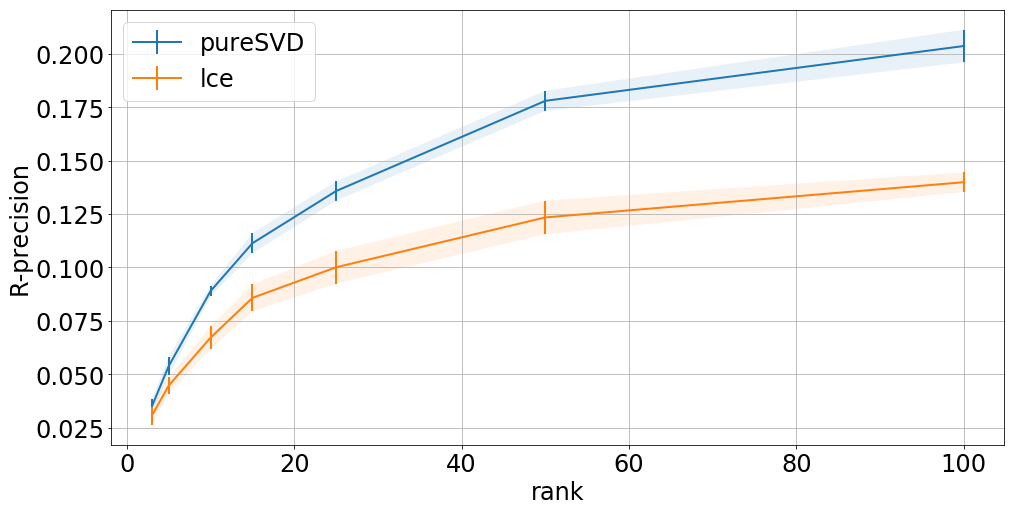

In [13]:
plt.errorbar(ranks, result['recall_svd'], yerr=result['recall_svd_std'], label='pureSVD')
plt.fill_between(ranks,
                 np.array(result['recall_svd']) + np.array(result['recall_svd_std']), 
                 np.array(result['recall_svd']) - np.array(result['recall_svd_std']),
                 alpha=0.1)
plt.errorbar(ranks, result['recall_lce'], yerr=result['recall_lce_std'], label='lce')
plt.fill_between(ranks,
                 np.array(result['recall_lce']) + np.array(result['recall_lce_std']), 
                 np.array(result['recall_lce']) - np.array(result['recall_lce_std']),
                 alpha=0.1)
plt.ylabel('R-precision')
plt.xlabel('rank')
plt.legend(loc='best')
plt.grid()

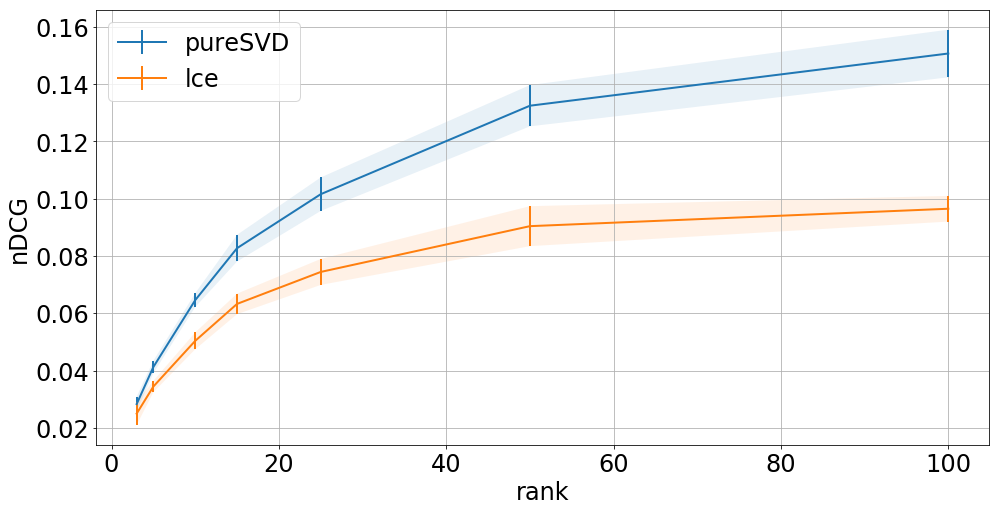

In [14]:
plt.errorbar(ranks, result['nDCG_svd'], yerr=result['nDCG_svd_std'], label='pureSVD')
plt.fill_between(ranks,
                 np.array(result['nDCG_svd']) + np.array(result['nDCG_svd_std']), 
                 np.array(result['nDCG_svd']) - np.array(result['nDCG_svd_std']),
                 alpha=0.1)
plt.errorbar(ranks, result['nDCG_lce'], yerr=result['nDCG_lce_std'], label='lce')
plt.fill_between(ranks,
                 np.array(result['nDCG_lce']) + np.array(result['nDCG_lce_std']), 
                 np.array(result['nDCG_lce']) - np.array(result['nDCG_lce_std']),
                 alpha=0.1)
plt.ylabel('nDCG')
plt.xlabel('rank')
plt.legend(loc='best')
plt.grid()